# Simulation of beam propagation
In this exercise, we simulate the beam propagation based on the Rayleigh-Sommerfeld diffraction formula. It involves fast-Fourier-transform numerical integration method.

- Direct integration (DI) numerical method as presented in the section 3 of the provided article
- It computes the transverse profile of a Hermite-Gaussian mode after numerical propagation over a given distance in free space. 
- The input parameters are: 
    - N: number of points of the numerical grid parameters 
    - L: Size of the simulated domain (N multiplied by the pitch)
    - w0: beam waist
    - m,n: orders m and n of the Hermite-Gaussian mode
    - lambda: optical wavelength
    - z: propagation distance
- All the relevant parameters for the input mode need to be parsed from a human-readable configuration; format to be chosen.

### Relevant packages

In [1]:
import math
import numpy as np
import scipy as sp
from scipy import special
from scipy.fft import fft2, ifft2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
# Setting for all matplotlib plot
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## Default functions

In [3]:
# The transverse profile of a Hermite-Gaussian mode
def hermiteGauss2D(m,n,x,y,w0):
    x,y=np.meshgrid(x,y)
    return special.eval_hermite(m,np.sqrt(2)*x/w0)*special.eval_hermite(n,np.sqrt(2)*y/w0)*np.exp(-(x**2+y**2)/(w0**2))

In [4]:
# The impulse response function
def Ht(lam, xa,ya,xo,yo, z=500):
    xt,yt = np.meshgrid(np.append(xo[0]-np.flip(xa[1:]), xo[:]-xa[0]),
                        np.append(yo[0]-np.flip(ya[1:]), yo[:]-ya[0]))
    rt = np.sqrt(xt**2+yt**2+z**2)
    return np.exp(1j*2*math.pi/lam*rt)/(2*math.pi*(rt**2))*z*(1/rt-1j*2*math.pi/lam)
# The mode after propagation
def So(lam, xa,ya,xo,yo,Ua,z=500):
    N = xa.shape[0]
    U=np.pad(Ua,((0,N-1),(0,N-1)))     # Padding intial input with zeros
    Ho = Ht(lam, xa,ya,xo,yo,z)
    St=ifft2(fft2(U)*fft2(Ho))*((L/N)**2)
    return St[N-1:,N-1:]


In [5]:
# Overlap between the original mode and the propagated mode
def Overlap(Ua,So):
    return abs(abs(np.sum(Ua*np.conjugate(So)))**2/np.sum(Ua*np.conjugate(Ua))/np.sum(So*np.conjugate(So)))
# Expression of the overlap for Gaussian mode
def OverlapGauss(z,zR):
    return (abs(1+1/(1+(z/zR)**2) + 1j*z*zR/(z**2+zR**2))**-2)*4/(1+(z/zR)**2)

## Selected cases

In [6]:
# Simulation parameters
N=1000
L=200

# The grid of the aperture
xa = np.linspace(-L/2,L/2-L/N,N)
ya = np.linspace(-L/2,L/2-L/N,N)

# The grid of the observation plane
xo = np.linspace(-L/2,L/2-L/N,N)
yo = np.linspace(-L/2,L/2-L/N,N)

### Case of Gaussian Beam

In [7]:
# parameters of the laser beam
lam = 1.55 
w0 = 40
# parameters specific to Hermite-Gaussian
m0=0 
n0=0

# Gaussian beam
Ua0=hermiteGauss2D(m0,n0,xa,ya,w0)

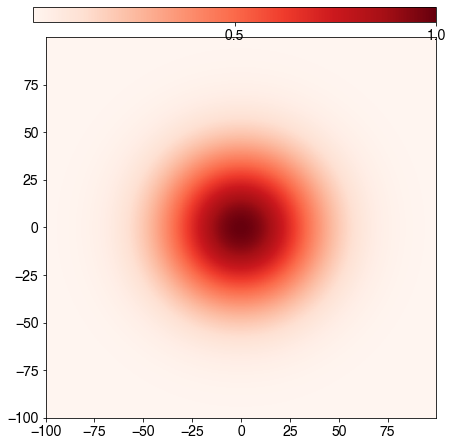

In [8]:
# Visualization of the Hermite-Gaussian beam
fig1=plt.figure(figsize=(7,7))
plt.pcolormesh(xa,ya, Ua0, cmap=plt.get_cmap('Reds'))

cbaxes = fig1.add_axes([0.1, 0.91, 0.8, 0.03])
plt.colorbar(cax = cbaxes,orientation="horizontal",anchor=(0.2,0.0), ticks=[0.0, 0.5, 1],format='%s')


In [9]:
# The simulated propagated mode
So0 = So(lam, xa,ya,xo,yo,Ua0,z=1000) # 0.5 mm of propagation

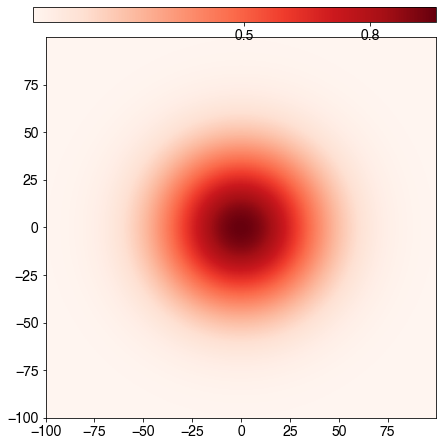

In [10]:
# Visualization of the amplitude of the propagated mode
fig1=plt.figure(figsize=(7,7))
plt.pcolormesh(xo,yo, abs(So0), cmap=plt.get_cmap('Reds'))
cbaxes = fig1.add_axes([0.1, 0.91, 0.8, 0.03])
plt.colorbar(cax = cbaxes,orientation="horizontal",anchor=(0.2,0.0), ticks=[0.0, 0.5,0.8],format='%s')


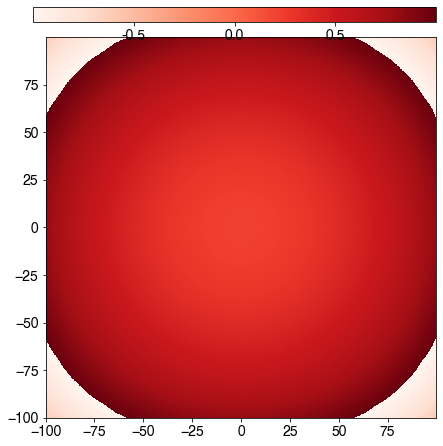

In [11]:
# Visualization of the phase (in the unit of pi) of the propagated mode
fig1=plt.figure(figsize=(7,7))
plt.pcolormesh(xo,yo, np.angle(So0)/math.pi, cmap=plt.get_cmap('Reds'))
cbaxes = fig1.add_axes([0.1, 0.91, 0.8, 0.03])
plt.colorbar(cax = cbaxes,orientation="horizontal",anchor=(0.2,0.0), ticks=[-1,-0.5, 0, 0.5,1],format='%s')


In [12]:
# Calculation of the overlap between the original mode and the propagated mode for different propagation distance
zinp = np.linspace(500,5000,10)
Sout0 = np.array([So(lam, xa,ya,xo,yo,Ua0,zo) for zo in zinp])
output0 = np.array([Overlap(Ua0,So) for So in Sout0])

In [13]:
output0[0] # The overlap after 0.5 mm of propagation

0.994093681490653

Text(0.5, 0, 'distance in mm')

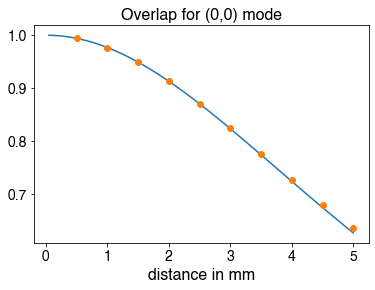

In [14]:
# Comparison with the analytical expression
zR = math.pi/lam*w0**2
z1 = np.linspace(50,5000,100)
pred0 = np.array([OverlapGauss(z,zR)  for z in z1])
plt.plot(z1/1000,pred0)
plt.plot(zinp/1000,output0,'o')
plt.title("Overlap for (0,0) mode",fontsize=16)
plt.gca().set_xlabel("distance in mm")

In [15]:
zR # The Rayleigh length

3242.93435209269

Text(0.5, 0, 'distance in the unit of the Rayleigh length')

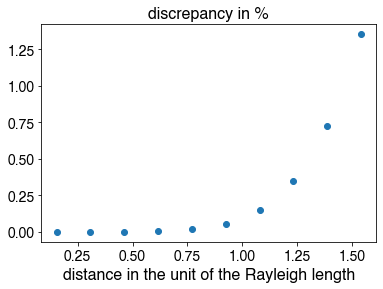

In [16]:
predOutput0 = np.array([OverlapGauss(z,zR)  for z in zinp])
plt.plot(zinp/zR,200*abs(output0-predOutput0)/(output0+predOutput0),'o')
plt.title("discrepancy in %",fontsize=16)
plt.gca().set_xlabel("distance in the unit of the Rayleigh length")

The discrepancies are weak for distances relatively smaller than the Rayleigh length.

### Case of Hermite Gaussian beam

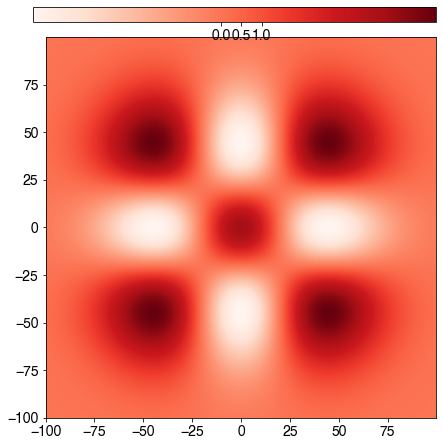

In [17]:
# parameters of the laser beam
lam = 1.55 
w0 = 40

# parameters specific to Hermite-Gaussian
m=2 
n=2

# The Hermite-Gaussian beam
Ua=hermiteGauss2D(m,n,xa,ya,w0)


# Visualization of the original Hermite-Gaussian mode
fig1=plt.figure(figsize=(7,7))
plt.pcolormesh(xa,ya, Ua, cmap=plt.get_cmap('Reds'))

cbaxes = fig1.add_axes([0.1, 0.91, 0.8, 0.03])
plt.colorbar(cax = cbaxes,orientation="horizontal",anchor=(0.2,0.0), ticks=[0.0, 0.5, 1],format='%s')


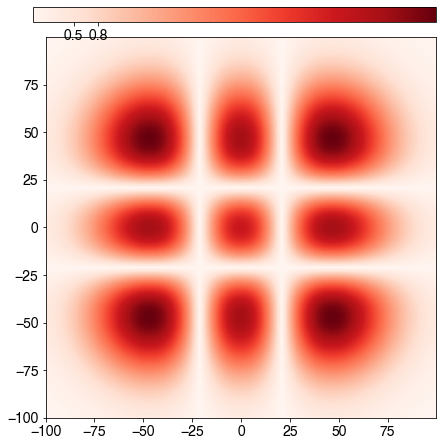

In [18]:
# The simulated propagated mode
SoHG = So(lam,xa,ya,xo,yo,Ua,z=1000) # 0.5 mm of propagation

# Visualization of the amplitude of the propagated mode
fig1=plt.figure(figsize=(7,7))
plt.pcolormesh(xo,yo, abs(SoHG), cmap=plt.get_cmap('Reds'))
cbaxes = fig1.add_axes([0.1, 0.91, 0.8, 0.03])
plt.colorbar(cax = cbaxes,orientation="horizontal",anchor=(0.2,0.0), ticks=[0.0, 0.5,0.8],format='%s')


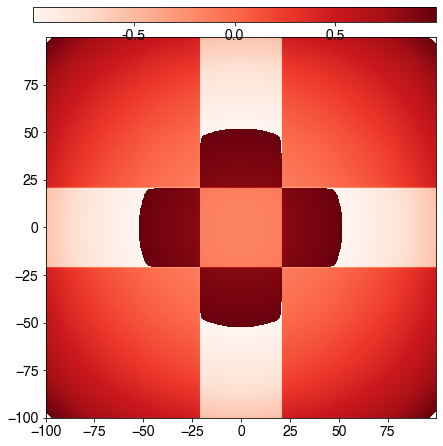

In [19]:
# Visualization of the phase (in the unit of pi) of the propagated mode
fig1=plt.figure(figsize=(7,7))
plt.pcolormesh(xo,yo, np.angle(SoHG)/math.pi, cmap=plt.get_cmap('Reds'))
cbaxes = fig1.add_axes([0.1, 0.91, 0.8, 0.03])
plt.colorbar(cax = cbaxes,orientation="horizontal",anchor=(0.2,0.0), ticks=[-1,-0.5, 0, 0.5,1],format='%s')


In [20]:
# Calculation of the overlap between the original mode and the propagated mode for different propagation distance
zinp = np.linspace(500,5000,10)
Sout = np.array([So(lam, xa,ya,xo,yo,Ua,zo) for zo in zinp])
output = np.array([Overlap(Ua,So) for So in Sout])

In [21]:
output[0] # The overlap after 0.5 mm of propagation

0.9598279280317026

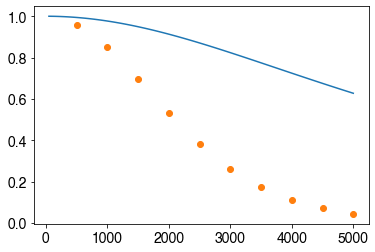

In [22]:
# Comparison with the case of Gaussian mode
z1 = np.linspace(50,5000,100)
plt.plot(z1,OverlapGauss(z1,zR))
plt.plot(zinp,output,'o')

The overlap decays faster compared with the case of Gaussian mode

## Reading from files

In [23]:
import pandas as pd
inputMode = pd.read_csv("input2.csv", delimiter='\t', encoding='latin1')
inputMode.head()

,N,L,w0,lam,m,n,dist
0,1000,200,40,1.55,0,0,500
1,1000,200,40,1.55,2,2,500


In [24]:
print("Calculating the overlap between the original mode and the propagated mode ...")
for ii in range(len(inputMode)):
    # Simulation parameters
    N = int(inputMode.iloc[ii]['N'])
    L = inputMode.iloc[ii]['L']                     # The simulated extent in transverse direction
    # The input beam
    w0 = inputMode.iloc[ii]['w0']     # the beam waist in micrometer, up to some constant
    lam = inputMode.iloc[ii]['lam']   # The wavelength in micrometer
    # parameters specific to Hermite-Gaussian
    m = int(inputMode.iloc[ii]['m'])
    n = int(inputMode.iloc[ii]['n'])
    # Physical simulation parameter
    dist = inputMode.iloc[ii]['dist']
    
    # The grid of the aperture
    xa = np.linspace(-L/2,L/2-L/N,N)
    ya = np.linspace(-L/2,L/2-L/N,N)

    # The grid of the observation plane
    xo = np.linspace(-L/2,L/2-L/N,N)
    yo = np.linspace(-L/2,L/2-L/N,N)
    
    # the mode
    print("Hermite-Gaussian "+"("+str(m)+","+str(n)+") mode after "+str(dist/1000)+"mm of propagation.")
    
    # The Hermite-Gaussian beam
    Ua=hermiteGauss2D(m,n,xa,ya,w0)
    
    # The simulated propagating beam
    SoHG = So(lam,xa,ya,xo,yo,Ua,z=dist)
    
    # Overlap
    ov = Overlap(Ua,SoHG)
    print("Overlap: "+ '{0:.4f}'.format(ov))
    
    # Case of Gaussian Beam
    if (m==0 and n==0):
        predOv = OverlapGauss(dist,zR=math.pi*w0**2/lam)
        print("Discrepancy with analytical value for Gaussian mode: "+ '{0:.2f}'.format(200*abs(predOv-ov)/(predOv+ov))+"%")
    
    
    


Calculating the overlap between the original mode and the propagated mode ...
Hermite-Gaussian (0,0) mode after 0.5mm of propagation.
Overlap: 0.9941
Discrepancy with analytical value for Gaussian mode: 0.00%
Hermite-Gaussian (2,2) mode after 0.5mm of propagation.
Overlap: 0.9598
